# Subscription Prediction with PySpark and MLlib

## Learning Objectives

At the end of this session, you will be able to 

- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [0]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2022-05-27 00:18:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  769K 1s
    50K .......... .......... .......... .......... .......... 17% 1.54M 0s
   100K .......... .......... .......... .......... .......... 26% 1.62M 0s
   150K .......... .......... .......... .......... .......... 35% 37.5M 0s
   200K .......... .......... .......... .......... .......... 44% 65.1M 0s
   250K .......... .......... .......... .......... .......... 53% 1.61M 0s
   300K .......... .......... .......... .......... .......... 61% 10.4M 0s
   350K .......... .......... .......... .......... .......... 70% 10.7M 0s
   400K ........

In [0]:
ls

bank.zip  conf/  eventlogs/  logs/  metastore_db/  preload_class.lst*


2. Unzip the file and use `ls` to see the files.

In [0]:
%%sh
unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [0]:
ls

bank-full.csv   bank.csv  conf/       logs/          preload_class.lst*
bank-names.txt  bank.zip  eventlogs/  metastore_db/


## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.

1. Load in the data and look at the columns.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('file:/databricks/driver/bank.csv', header=True, inferSchema=True, sep=';')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [0]:
df.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

In [0]:
display(df.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


3. To get a prettier result, it can be nice to use Pandas to display the smaller DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [0]:
import pandas as pd

pd_df = df.take(5)
pd_df = pd_df.toPandas()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2175791540743350> in <module>
      2 
      3 pd_df = df.take(5)
----> 4 pd_df = pd_df.toPandas()

AttributeError: 'list' object has no attribute 'toPandas'

4. How many datapoints are there in the dataset? Use the `.count()` method.

In [0]:
df.count()

Out[16]: 4521

5. Use the `.describe()` method to see summary statistics on the features.

    Note that the result of `.describe()` is a Spark DataFrame, so the contents won't be displayed. It only has 5 rows, so you can just convert the whole thing to a pandas DataFrame with `.toPandas()`.

In [0]:
display(df.summary())

summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
mean,41.17009511170095,null,null,null,null,1422.6578190665782,null,null,null,15.915284229152842,null,263.96129174961294,2.793629727936297,39.766644547666445,0.5425790754257908,null,null
stddev,10.576210958711263,null,null,null,null,3009.6381424673395,null,null,null,8.247667327229934,null,259.85663262468216,3.1098066601885823,100.12112444301656,1.6935623506071211,null,null
min,19,admin.,divorced,primary,no,-3313,no,no,cellular,1,apr,4,1,-1,0,failure,no
25%,33,null,null,null,null,69,null,null,null,9,null,104,1,-1,0,null,null
50%,39,null,null,null,null,444,null,null,null,16,null,185,2,-1,0,null,null
75%,49,null,null,null,null,1480,null,null,null,21,null,329,3,-1,0,null,null
max,87,unknown,single,unknown,yes,71188,yes,yes,unknown,31,sep,3025,50,871,25,unknown,yes


6. The above result includes the columns that are categorical, so don't have useful summary statistics. Let's limit to just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.
    
    Use the `.select()` method to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [0]:
numeric_features = [name for name, dtype in df.dtypes if dtype == 'int']
display(df.select(*numeric_features).summary())

summary,age,balance,day,duration,campaign,pdays,previous
count,4521,4521,4521,4521,4521,4521,4521
mean,41.17009511170095,1422.6578190665782,15.915284229152842,263.96129174961294,2.793629727936297,39.766644547666445,0.5425790754257908
stddev,10.576210958711263,3009.6381424673395,8.247667327229934,259.85663262468216,3.1098066601885823,100.12112444301656,1.6935623506071211
min,19,-3313,1,4,1,-1,0
25%,33,69,9,104,1,-1,0
50%,39,444,16,185,2,-1,0
75%,49,1480,21,329,3,-1,0
max,87,71188,31,3025,50,871,25


7. Run the following code to look at correlation between the numeric features. What do you see?

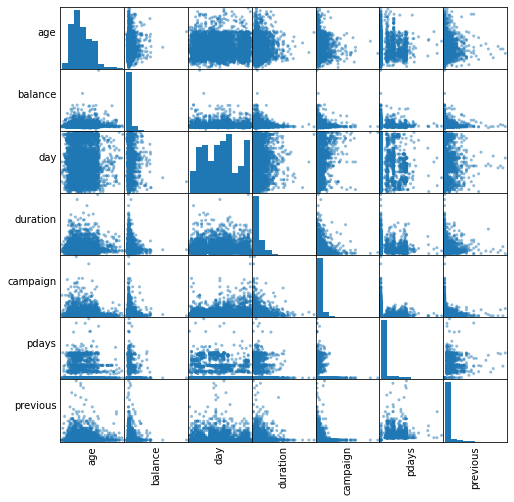

In [0]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

There aren't any highly correlated variables, so we will keep them all for the model. It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, so we will remove these two columns.

8. Use the `.drop()` method to drop the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `df`.

    Use the `.printSchema()` method to verify that `df` now has the correct columns.

In [0]:
df = df.drop('month', 'day')

## Part 3: Preparing Data for Machine Learning

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. The next code cell just sets this all up, it doesn't yet run these transformations on our data.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [0]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler( inputCols = assemblerInputs, outputCol = 'features')
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

1. Fit a pipeline on df.

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(df) # [YOUR CODE HERE]

2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [0]:
transformed_df = pipelineModel.transform(df) # [YOUR CODE HERE]
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vector (nullable = true)
 |-- housingIndex: double (nullable = false)
 |-- hou

In [0]:
display(transformed_df)

age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,jobIndex,jobclassVec,maritalIndex,maritalclassVec,educationIndex,educationclassVec,defaultIndex,defaultclassVec,housingIndex,housingclassVec,loanIndex,loanclassVec,contactIndex,contactclassVec,poutcomeIndex,poutcomeclassVec,label,features
30,unemployed,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown,no,8.0,"Map(vectorType -> sparse, length -> 11, indices -> List(8), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 3, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(8, 11, 15, 16, 18, 19, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 1787.0, 79.0, 1.0, -1.0))"
33,services,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure,no,4.0,"Map(vectorType -> sparse, length -> 11, indices -> List(4), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(4, 11, 13, 16, 17, 19, 22, 24, 25, 26, 27, 28, 29), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 4789.0, 220.0, 1.0, 339.0, 4.0))"
35,management,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure,no,0.0,"Map(vectorType -> sparse, length -> 11, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 12, 14, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 29), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35.0, 1350.0, 185.0, 1.0, 330.0, 1.0))"
30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown,no,0.0,"Map(vectorType -> sparse, length -> 11, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())",1.0,"Map(vectorType -> sparse, length -> 2, indices -> List(1), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `df.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `df`.

In [0]:
selectedCols = ['label', 'features'] + df.columns
df = transformed_df.select(*selectedCols) # [YOUR CODE HERE]
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. View the first five rows of the `df` DataFrame. Use either of the methods we did in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [0]:
display(df.take(5))

label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(8, 11, 15, 16, 18, 19, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 1787.0, 79.0, 1.0, -1.0))",30,unemployed,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown,no
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(4, 11, 13, 16, 17, 19, 22, 24, 25, 26, 27, 28, 29), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 4789.0, 220.0, 1.0, 339.0, 4.0))",33,services,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure,no
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 12, 14, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 29), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35.0, 1350.0, 185.0, 1.0, 330.0, 1.0))",35,management,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure,no
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 14, 16, 17, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 1476.0, 199.0, 4.0, -1.0))",30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown,no
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(1, 11, 13, 16, 17, 18, 20, 21, 24, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 59.0, 226.0, 1.0, -1.0))",59,blue-collar,married,secondary,no,0,yes,no,unknown,226,1,-1,0,unknown,no


5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [0]:
train, test = df.randomSplit([.7, .3],seed = 1234)

6. What are the sizes of the training and test sets?

In [0]:
print(train.count(), test.count())

3209 1312


## Part 5: Logistic Regression Model

- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a LogisticRegression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 10)
lrModel = lr.fit(train)

2. We can obtain the coefficients by using LogisticRegressionModel’s attributes. Look at the following plot of the beta coefficients.

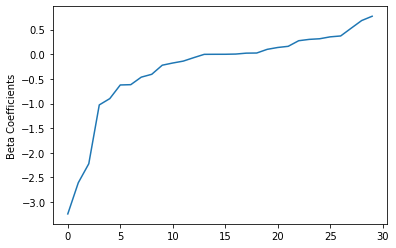

In [0]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [0]:
predictions = lrModel.transform(test) # [YOUR CODE HERE]

4. View the first 10 rows of the `predictions` DataFrame.

In [0]:
display(predictions.limit(10))

label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,rawPrediction,probability,prediction
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 19, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 466.0, 164.0, 1.0, -1.0))",31,management,married,secondary,no,466,yes,no,cellular,164,1,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(3.1309994078778347, -3.1309994078778347))","Map(vectorType -> dense, length -> 2, values -> List(0.95815348294007, 0.04184651705993003))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 19, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 1368.0, 129.0, 4.0, -1.0))",31,management,married,secondary,no,1368,yes,no,cellular,129,4,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(3.480848735448361, -3.480848735448361))","Map(vectorType -> dense, length -> 2, values -> List(0.9701379181627661, 0.029862081837233934))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 19, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 857.0, 238.0, 6.0, -1.0))",34,management,married,secondary,no,857,yes,no,cellular,238,6,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(3.1628796309011884, -3.1628796309011884))","Map(vectorType -> dense, length -> 2, values -> List(0.9594132262420972, 0.04058677375790276))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 3935.0, 129.0, 2.0, -1.0))",32,management,married,secondary,no,3935,yes,no,unknown,129,2,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(4.371932954244641, -4.371932954244641))","Map(vectorType -> dense, length -> 2, values -> List(0.9875306383413438, 0.012469361658656197))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 293.0, 162.0, 3.0, -1.0))",34,management,married,secondary,no,293,yes,no,unknown,162,3,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(4.316797508123688, -4.316797508123688))","Map(vectorType -> dense, length -> 2, values -> List(0.9868331348988613, 0.013166865101138736))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35.0, 839.0, 50.0, 3.0, -1.0))",35,management,married,secondary,no,839,yes,no,unknown,50,3,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(4.785969754642399, -4.785969754642399))","Map(vectorType -> dense, length -> 2, values -> List(0.9917230533888809, 0.008276946611119107))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 35.0, 1160.0, 116.0, 3.0, -1.0))",35,management,married,secondary,no,1160,yes,no,unknown,116,3,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(4.507158725074709, -4.507158725074709))","Map(vectorType -> dense, length -> 2, values -> List(0.9890905740262053, 0.01090942597379474))",0.0
0.0,"Map(vectorType -> sparse, length -> 30, indices -> List(0, 11, 13, 16, 17, 18, 20, 21, 24, 25, 26, 27, 28), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 80.0, 251.0, 3.0, -1.0))",36,management,married,secondary,no,80,yes,no,unknown,251,3,-1,0,unknown,no,"Map(vectorType -> dense, length -> 2, values -> List(3.9439864642760103, -3.9439864642760103))","Map(vectorType -> dense, length -> 2, values -> List(0.9809972595727013, 0.01900274042729866))",0.0
0.0,"Map(vectorType -> sparse, length -> 30,

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


## This is the PR Curve - AUC
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

Out[54]: 0.8570552318287007

## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [0]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 31|management|  0.0|[1.24988683560088...|       0.0|[0.92412595196564...|
| 31|management|  0.0|[1.25508575582375...|       0.0|[0.92485181160690...|
| 34|management|  0.0|[1.06641974401529...|       0.0|[0.89405426923033...|
| 32|management|  0.0|[1.24220541008129...|       0.0|[0.92304170885330...|
| 34|management|  0.0|[1.31471773711064...|       0.0|[0.93273213808106...|
| 35|management|  0.0|[1.32529724309899...|       0.0|[0.93404762189216...|
| 35|management|  0.0|[1.31471773711064...|       0.0|[0.93273213808106...|
| 36|management|  0.0|[1.28348877352745...|       0.0|[0.92870583447565...|
| 42|management|  0.0|[1.28348877352745...|       0.0|[0.92870583447565...|
| 43|management|  0.0|[1.32820590130028...|       0.0|[0.93440508047959...|
+---+-------

2. Run some cross validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

## Acknowledgements

This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)